In [39]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20
import seaborn as sns
from lbsNN import postprocess
from fastaUtils.profiles import parse_profile,profile_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def encode21(x):
    y=np.zeros((x.shape[0],x.shape[1]*21))
    for r in range(x.shape[0]):
        for c in range(x.shape[1]):
            y[r,21*c+x[r,c]]=1
    return y

## Define variables

In [41]:
x=np.load("datasets/jdm_A.int.npy").astype(int) # dataset
profile=parse_profile("datasets/jdm_A.int.profile")
profiledata=profile_data(profile)
np.random.shuffle(x)
x=x[:10000]
y=encode21(x)
outbasename="jdm_emb5"

q=5 # Embedding dimension
epochs=10000
comparetodata=None
Ngen=10000
reverse=False
bs=1024 # batch size

N=x.shape[1]
if comparetodata is not None:
    xc=np.load(comparetodata).astype(float)
alphabet=list("-ACDEFGHIKLMNPQRSTVWY")
outbasename=outbasename+"_NC" if not reversed else outbasename+"_CN"

In [42]:
print(N)

63


## Define model and helper classes

In [43]:
from tensorflow.keras.regularizers import Regularizer
import tensorflow.keras.backend as K
from tensorflow.python.ops import math_ops
import math

def _check_penalty_number(x):
  """check penalty number availability, raise ValueError if failed."""
  if not isinstance(x, (float, int)):
    raise ValueError(('Value: {} is not a valid regularization penalty number, '
                      'expected an int or float value').format(x))

  if math.isinf(x) or math.isnan(x):
    raise ValueError(
        ('Value: {} is not a valid regularization penalty number, '
         'a positive/negative infinity or NaN is not a property value'
        ).format(x))

class L2Autoregressive(Regularizer):
  def __init__(self, l2, N, q, reverse=False,  **kwargs):  # pylint: disable=redefined-outer-name
    l2 = kwargs.pop('l', l2)  # Backwards compatibility
    if kwargs:
      raise TypeError('Argument(s) not recognized: %s' % (kwargs,))

    l2 = 0.01 if l2 is None else l2
    _check_penalty_number(l2)

    self.l2 = K.cast_to_floatx(l2)
    self.axis= 0 if reverse else 1
    self.factors = []
    for n in range(N):
        self.factors.extend([1./((n+1)*q) for i in range(q)])
    if reverse:
        self.factors=reversed(self.factors)
    self.factors=np.array(self.factors)
    self.factors/=np.sum(self.factors)
    self.factors=K.constant(self.factors)
    print("Initialized: {}".format(l2))
  def __call__(self, x):
#     l=self.l2 * math_ops.reduce_sum(math_ops.square(x))
    l=self.l2 * math_ops.reduce_sum(tf.multiply(self.factors,math_ops.reduce_sum(math_ops.square(x),axis=self.axis)))
    return l

  def get_config(self):
    return {'l2': float(self.l2)}

In [44]:
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [45]:
from tensorflow.python.keras import activations
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers.ops import core as core_ops
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_shape

class AutoregressiveLayer(tf.keras.layers.Layer):
  def __init__(self,
               units,
               qin,
               qout=None,
               activation=None,
               use_bias=True,
               kernel_initializer='zeros',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               isfirst=True,
               reverse=False,
               **kwargs):
    super(AutoregressiveLayer, self).__init__( activity_regularizer=activity_regularizer, **kwargs)

    self.units = int(units) if not isinstance(units, int) else units
    self.qin = int(qin) if not isinstance(qin, int) else qin
    if qout is None:
        qout=qin
    self.qout = int(qout) if not isinstance(qout, int) else qout
    self.activation = activations.get(activation)
    self.use_bias = use_bias
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.input_spec = InputSpec(min_ndim=2)
    self.supports_masking = True

    self.N=self.units//self.qout
    self.reverse=reverse
    self.mask=np.zeros((self.N*self.qin,self.units))
    for c in range(self.N):
        if isfirst:
            self.mask[self.qin*c:self.qin*c+self.qin,self.qout*c+self.qout:]=1
        else:
            self.mask[self.qin*c:self.qin*c+self.qin,self.qout*c:]=1
    if self.reverse:
        self.mask=self.mask.T

    self.mask=tf.constant(self.mask,dtype=tf.float32)
    
    
    
  def build(self, input_shape):
    dtype = dtypes.as_dtype(self.dtype or K.floatx())
    if not (dtype.is_floating or dtype.is_complex):
      raise TypeError('Unable to build `Dense` layer with non-floating point '
                      'dtype %s' % (dtype,))

    input_shape = tensor_shape.TensorShape(input_shape)
    last_dim = tensor_shape.dimension_value(input_shape[-1])
    if last_dim is None:
      raise ValueError('The last dimension of the inputs to `Dense` '
                       'should be defined. Found `None`.')
    self.input_spec = InputSpec(min_ndim=2, axes={-1: last_dim})  
    
    self.kernel = self.add_weight(
        'kernel',
        shape=[self.N*self.qin,self.units],
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self.use_bias:
      self.bias = self.add_weight(
          'bias',
          shape=[self.units,],
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self.bias = None
    
    self.built = True

  def call(self, inputs):
    return core_ops.dense(
        inputs,
        tf.multiply(self.kernel,self.mask),
        self.bias,
        self.activation,
        dtype=self._compute_dtype_object)

  def compute_output_shape(self, input_shape):
    input_shape = tensor_shape.TensorShape(input_shape)
    input_shape = input_shape.with_rank_at_least(2)
    if tensor_shape.dimension_value(input_shape[-1]) is None:
      raise ValueError(
          'The innermost dimension of input_shape must be defined, but saw: %s'
          % input_shape)
    
    return input_shape[:-1].concatenate(self.units)

  def get_config(self):
    config = super(Dense, self).get_config()
    config.update({
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'activity_regularizer':
            regularizers.serialize(self.activity_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint)
    })
    return config

In [46]:
def generateSequences(model,M,N,q=21,reverse=False,verbose=True):
    choices=list(range(q))

    sequence=np.zeros((M,N))
    for idx in range(N):
        if verbose:
            print("{}/{}".format(idx+1,N),end='\r')
        u=N-idx-1 if reverse else idx
        prob=model.predict(sequence)[:,u,:]
        for m in range(M):
            r=rnd.choice(choices,size=1,p=prob[m,:])
            sequence[m,u]=r
    return sequence

def decodeSequences(sequences,alphabet):
    N=sequences.shape[1]
    decoded=[]
    for n in range(N):
        s=sequences[:,n]
        chars=[alphabet[int(i)] for i in s]
        decoded.append(chars)
    decoded=np.array(decoded,dtype='str').T
    sequences=[]
    for dec in decoded:
        sequences.append("".join(dec))
    return sequences

## Define model

In [47]:
from tensorflow.keras.regularizers import l2

#kernelreg=L2Autoregressive(0.01*N*q)

In=tf.keras.layers.Input((N,))
Emb=tf.keras.layers.Embedding(21,q)(In)
fltemb=tf.keras.layers.Reshape( (q*N,) )(Emb)
energy=AutoregressiveLayer(21*N,qin=q,qout=21,reverse=reverse,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear')(fltemb)
#energy=AutoregressiveLayer(21*N,qin=q,qout=21,reverse=reverse,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear',isfirst=False)(energy)
energy=tf.keras.layers.Reshape((N,21))(energy)
Out0=tf.nn.log_softmax(energy,axis=-1)
Out=tf.keras.layers.Flatten()(Out0)
model=tf.keras.models.Model(In,Out)
model2=tf.keras.models.Model(In,fltemb)

In [48]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 63, 5)             105       
_________________________________________________________________
reshape_4 (Reshape)          (None, 315)               0         
_________________________________________________________________
autoregressive_layer_2 (Auto (None, 1323)              418068    
_________________________________________________________________
reshape_5 (Reshape)          (None, 63, 21)            0         
_________________________________________________________________
tf.nn.log_softmax_2 (TFOpLam (None, 63, 21)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1323)              0   

In [49]:
model(x)

<tf.Tensor: shape=(10000, 1323), dtype=float32, numpy=
array([[-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225],
       [-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225],
       [-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225],
       ...,
       [-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225],
       [-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225],
       [-3.0445225, -3.0445225, -3.0445225, ..., -3.0445225, -3.0445225,
        -3.0445225]], dtype=float32)>

### Callbacks

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='auto')
checkpoint=ModelCheckpoint("checkpoints/{}_weights".format(outbasename), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
reduce_lr=ReduceLROnPlateau(factor=0.2,patience=20,monitor='loss')
lr_finder = LRFinder(min_lr=1e-6, max_lr=1,reload_weights=False)

### Find best learning rate

Epoch 1/10
10/10 [==============================] - 0s 9ms/step - loss: 191.5500
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 191.4523
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 191.4499
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 191.4386
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 191.3938
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 191.2160
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 190.5051
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 187.4104
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 142.8423
Epoch 10/10
10/10 [==============================] - 0s 8ms/step - loss: 96.3245


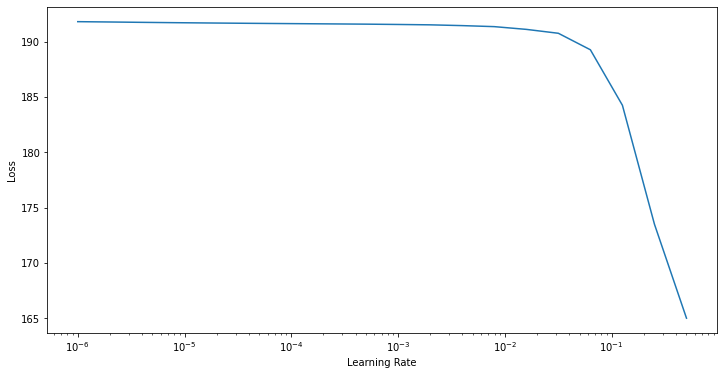

In [51]:
model.compile(optimizer='sgd', loss=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1)))
model.fit(x, y, callbacks=[lr_finder,checkpoint], epochs=10, shuffle=True, batch_size=bs)

### Fit model

In [52]:
optimizer=tf.keras.optimizers.SGD(lr=1.e-3)
model.compile(optimizer=optimizer, loss=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1)))

In [53]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 63, 5)             105       
_________________________________________________________________
reshape_4 (Reshape)          (None, 315)               0         
_________________________________________________________________
autoregressive_layer_2 (Auto (None, 1323)              418068    
_________________________________________________________________
reshape_5 (Reshape)          (None, 63, 21)            0         
_________________________________________________________________
tf.nn.log_softmax_2 (TFOpLam (None, 63, 21)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1323)              0   

In [54]:
try:
    model.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

hist=model.fit(x,y,epochs=epochs,shuffle=True,callbacks=[earlystopping,checkpoint,reduce_lr], batch_size=bs)

try:
    model.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

Epoch 1/10000
10/10 [==============================] - 0s 8ms/step - loss: 75.6682
Epoch 2/10000
10/10 [==============================] - 0s 8ms/step - loss: 67.4422
Epoch 3/10000
10/10 [==============================] - 0s 8ms/step - loss: 62.7559
Epoch 4/10000
10/10 [==============================] - 0s 8ms/step - loss: 58.9359
Epoch 5/10000
10/10 [==============================] - 0s 8ms/step - loss: 56.4109
Epoch 6/10000
10/10 [==============================] - 0s 8ms/step - loss: 54.9247
Epoch 7/10000
10/10 [==============================] - 0s 8ms/step - loss: 53.5951
Epoch 8/10000
10/10 [==============================] - 0s 8ms/step - loss: 52.1708
Epoch 9/10000
10/10 [==============================] - 0s 8ms/step - loss: 51.1352
Epoch 10/10000
10/10 [==============================] - 0s 8ms/step - loss: 50.7488
Epoch 11/10000
10/10 [==============================] - 0s 9ms/step - loss: 50.0874
Epoch 12/10000
10/10 [==============================] - 0s 8ms/step - loss: 49.3023
E

10/10 [==============================] - 0s 8ms/step - loss: 40.6552
Epoch 99/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.7183
Epoch 100/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.4456
Epoch 101/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.9484
Epoch 102/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.2289
Epoch 103/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.3889
Epoch 104/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.1128
Epoch 105/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.0730
Epoch 106/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.6955
Epoch 107/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.1476
Epoch 108/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.5322
Epoch 109/10000
10/10 [==============================] - 0s 8ms/step - loss: 40.00

10/10 [==============================] - 0s 8ms/step - loss: 39.3127
Epoch 195/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.9059
Epoch 196/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.0054
Epoch 197/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.1552
Epoch 198/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.3469
Epoch 199/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.3304
Epoch 200/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.4824
Epoch 201/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.3881
Epoch 202/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.1260
Epoch 203/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.4691
Epoch 204/10000
10/10 [==============================] - 0s 8ms/step - loss: 39.1460
Epoch 205/10000
10/10 [==============================] - 0s 8ms/step - loss: 38.2

10/10 [==============================] - 0s 8ms/step - loss: 36.6217
Epoch 291/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.7036
Epoch 292/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.6163
Epoch 293/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.3794
Epoch 294/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.5004
Epoch 295/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.3383
Epoch 296/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.5091
Epoch 297/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.5098
Epoch 298/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.3339
Epoch 299/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.6456
Epoch 300/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.4902
Epoch 301/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.5

10/10 [==============================] - 0s 8ms/step - loss: 36.0811
Epoch 387/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.9155
Epoch 388/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.2670
Epoch 389/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.9823
Epoch 390/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.9932
Epoch 391/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.0776
Epoch 392/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.9623
Epoch 393/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.1458
Epoch 394/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.1862
Epoch 395/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.0762
Epoch 396/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.1182
Epoch 397/10000
10/10 [==============================] - 0s 8ms/step - loss: 36.0

10/10 [==============================] - 0s 8ms/step - loss: 35.8148
Epoch 483/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6762
Epoch 484/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.7907
Epoch 485/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.7383
Epoch 486/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.7449
Epoch 487/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6814
Epoch 488/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.8423
Epoch 489/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6737
Epoch 490/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.7604
Epoch 491/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6431
Epoch 492/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6246
Epoch 493/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5

10/10 [==============================] - 0s 8ms/step - loss: 35.6813
Epoch 579/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5091
Epoch 580/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5435
Epoch 581/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5422
Epoch 582/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5184
Epoch 583/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.3780
Epoch 584/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.6629
Epoch 585/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5308
Epoch 586/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5034
Epoch 587/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.5707
Epoch 588/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.4363
Epoch 589/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.4

10/10 [==============================] - 0s 8ms/step - loss: 35.0205
Epoch 675/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0220
Epoch 676/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0034
Epoch 677/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.3272
Epoch 678/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2742
Epoch 679/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.3365
Epoch 680/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2180
Epoch 681/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.3310
Epoch 682/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1540
Epoch 683/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1466
Epoch 684/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1174
Epoch 685/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1

10/10 [==============================] - 0s 8ms/step - loss: 35.0744
Epoch 771/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9702
Epoch 772/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1214
Epoch 773/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.3471
Epoch 774/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0265
Epoch 775/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1595
Epoch 776/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2426
Epoch 777/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1603
Epoch 778/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2620
Epoch 779/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0227
Epoch 780/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9780
Epoch 781/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2

10/10 [==============================] - 0s 9ms/step - loss: 34.9990
Epoch 867/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.9907
Epoch 868/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0299
Epoch 869/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2511
Epoch 870/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1017
Epoch 871/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1149
Epoch 872/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1618
Epoch 873/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0983
Epoch 874/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2973
Epoch 875/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1249
Epoch 876/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1136
Epoch 877/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0

10/10 [==============================] - 0s 8ms/step - loss: 35.1464
Epoch 963/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9365
Epoch 964/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9855
Epoch 965/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0687
Epoch 966/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0567
Epoch 967/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0020
Epoch 968/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1552
Epoch 969/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9277
Epoch 970/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9730
Epoch 971/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9841
Epoch 972/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0344
Epoch 973/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8

10/10 [==============================] - 0s 8ms/step - loss: 35.0782
Epoch 1058/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9987
Epoch 1059/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.2267
Epoch 1060/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0015
Epoch 1061/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0366
Epoch 1062/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0854
Epoch 1063/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8544
Epoch 1064/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0467
Epoch 1065/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8232
Epoch 1066/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.1197
Epoch 1067/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0549
Epoch 1068/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 35.0934
Epoch 1153/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9114
Epoch 1154/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9231
Epoch 1155/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8443
Epoch 1156/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0204
Epoch 1157/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9111
Epoch 1158/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8468
Epoch 1159/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9111
Epoch 1160/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9609
Epoch 1161/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9746
Epoch 1162/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8895
Epoch 1163/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.8640
Epoch 1248/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0458
Epoch 1249/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0664
Epoch 1250/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7794
Epoch 1251/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0356
Epoch 1252/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9942
Epoch 1253/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7106
Epoch 1254/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8195
Epoch 1255/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0511
Epoch 1256/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9277
Epoch 1257/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9306
Epoch 1258/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 35.0416
Epoch 1343/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8427
Epoch 1344/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8828
Epoch 1345/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7447
Epoch 1346/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8015
Epoch 1347/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7265
Epoch 1348/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7765
Epoch 1349/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8516
Epoch 1350/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9193
Epoch 1351/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8651
Epoch 1352/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0326
Epoch 1353/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.8354
Epoch 1438/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0429
Epoch 1439/10000
10/10 [==============================] - 0s 8ms/step - loss: 35.0704
Epoch 1440/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8496
Epoch 1441/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8321
Epoch 1442/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6919
Epoch 1443/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7319
Epoch 1444/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8153
Epoch 1445/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9608
Epoch 1446/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8063
Epoch 1447/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8908
Epoch 1448/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.9796
Epoch 1533/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8584
Epoch 1534/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8230
Epoch 1535/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8172
Epoch 1536/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6940
Epoch 1537/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7551
Epoch 1538/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.6699
Epoch 1539/10000
10/10 [==============================] - 0s 10ms/step - loss: 34.7781
Epoch 1540/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8365
Epoch 1541/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.8964
Epoch 1542/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7091
Epoch 1543/10000
10/10 [==============================] - 0s 8ms/step 

10/10 [==============================] - 0s 8ms/step - loss: 34.7497
Epoch 1628/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9469
Epoch 1629/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6767
Epoch 1630/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5754
Epoch 1631/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6529
Epoch 1632/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7116
Epoch 1633/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6451
Epoch 1634/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7246
Epoch 1635/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6671
Epoch 1636/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7124
Epoch 1637/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4597
Epoch 1638/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.8314
Epoch 1723/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5944
Epoch 1724/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4779
Epoch 1725/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5343
Epoch 1726/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7281
Epoch 1727/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6605
Epoch 1728/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7521
Epoch 1729/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7382
Epoch 1730/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7272
Epoch 1731/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7121
Epoch 1732/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6966
Epoch 1733/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.7036
Epoch 1818/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6824
Epoch 1819/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7034
Epoch 1820/10000
10/10 [==============================] - 0s 10ms/step - loss: 34.6333
Epoch 1821/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9026
Epoch 1822/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6727
Epoch 1823/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7230
Epoch 1824/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7255
Epoch 1825/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6810
Epoch 1826/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7103
Epoch 1827/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8402
Epoch 1828/10000
10/10 [==============================] - 0s 8ms/step 

10/10 [==============================] - 0s 8ms/step - loss: 34.5623
Epoch 1913/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7666
Epoch 1914/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.8017
Epoch 1915/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7394
Epoch 1916/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7806
Epoch 1917/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6553
Epoch 1918/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6353
Epoch 1919/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5249
Epoch 1920/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7332
Epoch 1921/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6496
Epoch 1922/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6760
Epoch 1923/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 9ms/step - loss: 34.8574
Epoch 2008/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6747
Epoch 2009/10000
10/10 [==============================] - 0s 10ms/step - loss: 34.7270
Epoch 2010/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7171
Epoch 2011/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7569
Epoch 2012/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6436
Epoch 2013/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.4892
Epoch 2014/10000
10/10 [==============================] - 0s 11ms/step - loss: 34.7784
Epoch 2015/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7223
Epoch 2016/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6876
Epoch 2017/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.9093
Epoch 2018/10000
10/10 [==============================] - 0s 8ms/step

10/10 [==============================] - 0s 8ms/step - loss: 34.5490
Epoch 2103/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7665
Epoch 2104/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4989
Epoch 2105/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5120
Epoch 2106/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5653
Epoch 2107/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5008
Epoch 2108/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6593
Epoch 2109/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5620
Epoch 2110/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7686
Epoch 2111/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6628
Epoch 2112/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6404
Epoch 2113/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.5357
Epoch 2198/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6037
Epoch 2199/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3360
Epoch 2200/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5998
Epoch 2201/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7647
Epoch 2202/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5214
Epoch 2203/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.7015
Epoch 2204/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2790
Epoch 2205/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5016
Epoch 2206/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5491
Epoch 2207/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.4411
Epoch 2208/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.4833
Epoch 2293/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.7013
Epoch 2294/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3301
Epoch 2295/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6321
Epoch 2296/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5700
Epoch 2297/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6087
Epoch 2298/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5518
Epoch 2299/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5678
Epoch 2300/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3237
Epoch 2301/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5088
Epoch 2302/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6385
Epoch 2303/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.3913
Epoch 2388/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5324
Epoch 2389/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4536
Epoch 2390/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5290
Epoch 2391/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5066
Epoch 2392/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5551
Epoch 2393/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6249
Epoch 2394/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5241
Epoch 2395/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1926
Epoch 2396/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4872
Epoch 2397/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4771
Epoch 2398/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.6093
Epoch 2483/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6211
Epoch 2484/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5132
Epoch 2485/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5240
Epoch 2486/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4784
Epoch 2487/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4429
Epoch 2488/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5432
Epoch 2489/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4696
Epoch 2490/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3565
Epoch 2491/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5239
Epoch 2492/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.6824
Epoch 2493/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.4989
Epoch 2578/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4710
Epoch 2579/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3998
Epoch 2580/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3578
Epoch 2581/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4789
Epoch 2582/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4337
Epoch 2583/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3275
Epoch 2584/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4226
Epoch 2585/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4208
Epoch 2586/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5473
Epoch 2587/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3915
Epoch 2588/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1855
Epoch 2673/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4250
Epoch 2674/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4458
Epoch 2675/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4156
Epoch 2676/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2944
Epoch 2677/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4487
Epoch 2678/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5010
Epoch 2679/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3910
Epoch 2680/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4077
Epoch 2681/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3474
Epoch 2682/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1376
Epoch 2683/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.6921
Epoch 2768/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2674
Epoch 2769/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3477
Epoch 2770/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4199
Epoch 2771/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2294
Epoch 2772/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2423
Epoch 2773/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3646
Epoch 2774/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2797
Epoch 2775/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4668
Epoch 2776/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3625
Epoch 2777/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2081
Epoch 2778/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.5067
Epoch 2863/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3531
Epoch 2864/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3241
Epoch 2865/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2801
Epoch 2866/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4811
Epoch 2867/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2997
Epoch 2868/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4575
Epoch 2869/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1450
Epoch 2870/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5029
Epoch 2871/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4167
Epoch 2872/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3164
Epoch 2873/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.2346
Epoch 2958/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2379
Epoch 2959/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4840
Epoch 2960/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4658
Epoch 2961/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4652
Epoch 2962/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2249
Epoch 2963/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2703
Epoch 2964/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4130
Epoch 2965/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2565
Epoch 2966/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3344
Epoch 2967/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3639
Epoch 2968/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1640
Epoch 3053/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5025
Epoch 3054/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5390
Epoch 3055/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4201
Epoch 3056/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5030
Epoch 3057/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4254
Epoch 3058/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2743
Epoch 3059/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3999
Epoch 3060/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.5376
Epoch 3061/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1653
Epoch 3062/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3216
Epoch 3063/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.3281
Epoch 3148/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0834
Epoch 3149/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1903
Epoch 3150/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3044
Epoch 3151/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3115
Epoch 3152/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2443
Epoch 3153/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3009
Epoch 3154/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1380
Epoch 3155/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4476
Epoch 3156/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1646
Epoch 3157/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3583
Epoch 3158/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.0625
Epoch 3243/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2142
Epoch 3244/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4105
Epoch 3245/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3866
Epoch 3246/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3025
Epoch 3247/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3155
Epoch 3248/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2159
Epoch 3249/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1865
Epoch 3250/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1552
Epoch 3251/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2111
Epoch 3252/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2276
Epoch 3253/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.2530
Epoch 3338/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9594
Epoch 3339/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3339
Epoch 3340/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.4306
Epoch 3341/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2603
Epoch 3342/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2907
Epoch 3343/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3661
Epoch 3344/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1132
Epoch 3345/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1967
Epoch 3346/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2677
Epoch 3347/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0688
Epoch 3348/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.2115
Epoch 3433/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1513
Epoch 3434/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3757
Epoch 3435/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2309
Epoch 3436/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3543
Epoch 3437/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1159
Epoch 3438/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2256
Epoch 3439/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0282
Epoch 3440/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2173
Epoch 3441/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1047
Epoch 3442/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3575
Epoch 3443/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1441
Epoch 3528/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1145
Epoch 3529/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2396
Epoch 3530/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2735
Epoch 3531/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0767
Epoch 3532/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1930
Epoch 3533/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2263
Epoch 3534/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1827
Epoch 3535/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2642
Epoch 3536/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2967
Epoch 3537/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1727
Epoch 3538/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1209
Epoch 3623/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1343
Epoch 3624/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0480
Epoch 3625/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1760
Epoch 3626/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1928
Epoch 3627/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1452
Epoch 3628/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1413
Epoch 3629/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0296
Epoch 3630/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1866
Epoch 3631/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1069
Epoch 3632/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.1342
Epoch 3633/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1981
Epoch 3718/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0650
Epoch 3719/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2786
Epoch 3720/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3535
Epoch 3721/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0607
Epoch 3722/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2850
Epoch 3723/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1553
Epoch 3724/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9326
Epoch 3725/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.3675
Epoch 3726/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9907
Epoch 3727/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1266
Epoch 3728/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1200
Epoch 3813/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1984
Epoch 3814/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0577
Epoch 3815/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0361
Epoch 3816/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2763
Epoch 3817/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2291
Epoch 3818/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1551
Epoch 3819/10000
10/10 [==============================] - 0s 9ms/step - loss: 33.9352
Epoch 3820/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9899
Epoch 3821/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0375
Epoch 3822/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0502
Epoch 3823/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.0910
Epoch 3908/10000
10/10 [==============================] - 0s 9ms/step - loss: 33.9192
Epoch 3909/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9508
Epoch 3910/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0256
Epoch 3911/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0473
Epoch 3912/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0704
Epoch 3913/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1888
Epoch 3914/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2208
Epoch 3915/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2595
Epoch 3916/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2177
Epoch 3917/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9033
Epoch 3918/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1616
Epoch 4003/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0367
Epoch 4004/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1814
Epoch 4005/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1465
Epoch 4006/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1158
Epoch 4007/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0523
Epoch 4008/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0954
Epoch 4009/10000
10/10 [==============================] - 0s 9ms/step - loss: 34.0911
Epoch 4010/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0696
Epoch 4011/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1216
Epoch 4012/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1272
Epoch 4013/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1628
Epoch 4098/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0709
Epoch 4099/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1889
Epoch 4100/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0290
Epoch 4101/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9967
Epoch 4102/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9060
Epoch 4103/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0949
Epoch 4104/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8961
Epoch 4105/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2400
Epoch 4106/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9113
Epoch 4107/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1405
Epoch 4108/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 34.1169
Epoch 4193/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0975
Epoch 4194/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1262
Epoch 4195/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8067
Epoch 4196/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9692
Epoch 4197/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0325
Epoch 4198/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0545
Epoch 4199/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0521
Epoch 4200/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0600
Epoch 4201/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1092
Epoch 4202/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1627
Epoch 4203/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 9ms/step - loss: 34.0357
Epoch 4288/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0528
Epoch 4289/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2085
Epoch 4290/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1728
Epoch 4291/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0695
Epoch 4292/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1707
Epoch 4293/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0887
Epoch 4294/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1172
Epoch 4295/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.2291
Epoch 4296/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1114
Epoch 4297/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0965
Epoch 4298/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 33.9711
Epoch 4383/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9397
Epoch 4384/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0188
Epoch 4385/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9228
Epoch 4386/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8958
Epoch 4387/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0706
Epoch 4388/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0372
Epoch 4389/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0434
Epoch 4390/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9276
Epoch 4391/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0713
Epoch 4392/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0319
Epoch 4393/10000
10/10 [==============================] - 0s 9ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 33.9389
Epoch 4478/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1170
Epoch 4479/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9959
Epoch 4480/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9603
Epoch 4481/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1065
Epoch 4482/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9429
Epoch 4483/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9831
Epoch 4484/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9215
Epoch 4485/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9394
Epoch 4486/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9777
Epoch 4487/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9691
Epoch 4488/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 33.9657
Epoch 4573/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9997
Epoch 4574/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1750
Epoch 4575/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0114
Epoch 4576/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1579
Epoch 4577/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9193
Epoch 4578/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8907
Epoch 4579/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9089
Epoch 4580/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9277
Epoch 4581/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9457
Epoch 4582/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9354
Epoch 4583/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 33.9133
Epoch 4668/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8802
Epoch 4669/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9530
Epoch 4670/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.1595
Epoch 4671/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9845
Epoch 4672/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8866
Epoch 4673/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9236
Epoch 4674/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0536
Epoch 4675/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9638
Epoch 4676/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0933
Epoch 4677/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8592
Epoch 4678/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 9ms/step - loss: 33.9661
Epoch 4763/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0291
Epoch 4764/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8016
Epoch 4765/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9448
Epoch 4766/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9947
Epoch 4767/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9600
Epoch 4768/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9309
Epoch 4769/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0510
Epoch 4770/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9203
Epoch 4771/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0423
Epoch 4772/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9159
Epoch 4773/10000
10/10 [==============================] - 0s 8ms/step -

10/10 [==============================] - 0s 8ms/step - loss: 33.7618
Epoch 4858/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9857
Epoch 4859/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9682
Epoch 4860/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9686
Epoch 4861/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0188
Epoch 4862/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9154
Epoch 4863/10000
10/10 [==============================] - 0s 8ms/step - loss: 34.0598
Epoch 4864/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9081
Epoch 4865/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8274
Epoch 4866/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.8125
Epoch 4867/10000
10/10 [==============================] - 0s 8ms/step - loss: 33.9535
Epoch 4868/10000
10/10 [==============================] - 0s 8ms/step -

## Display results

### Show weights

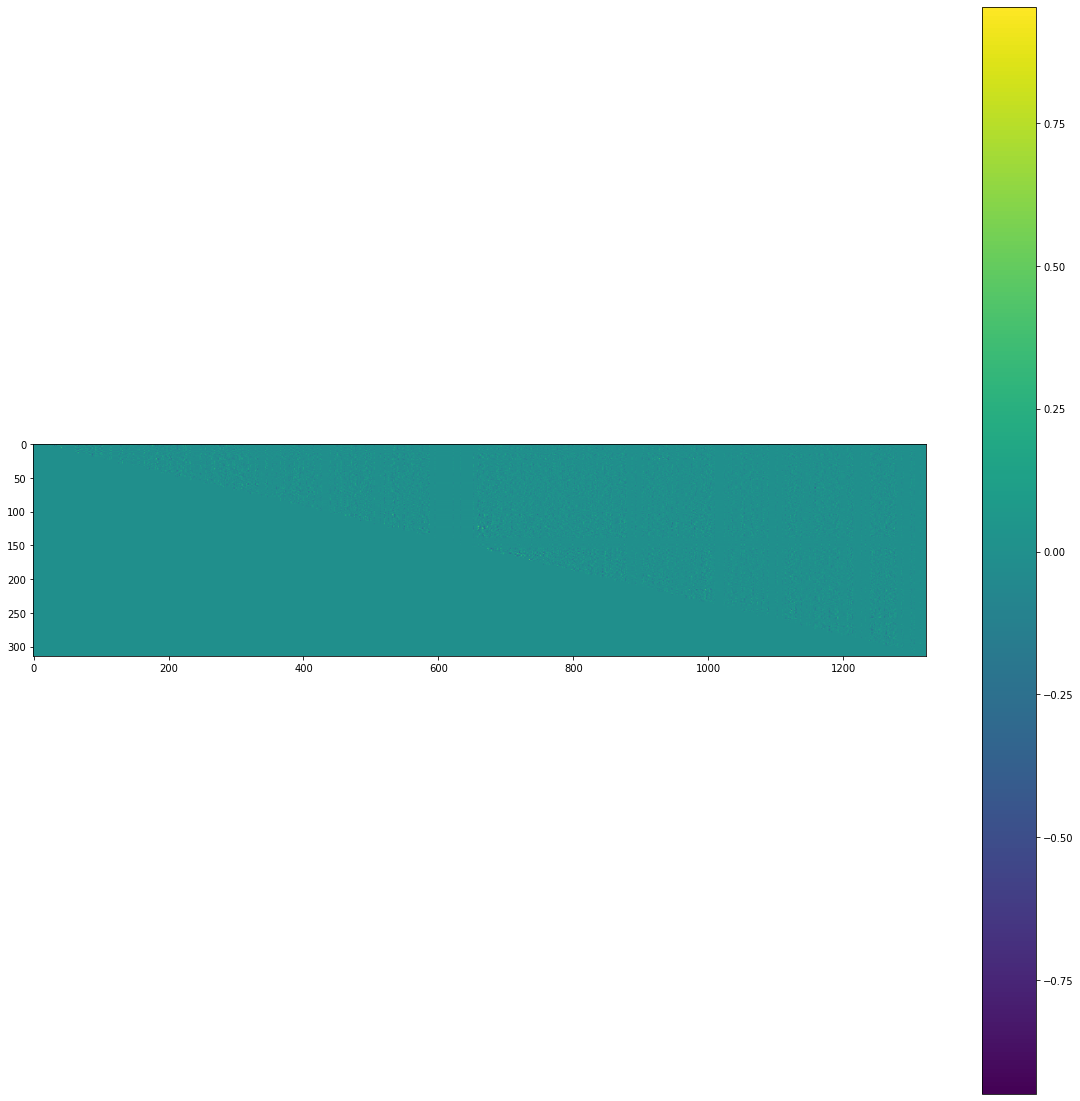

In [56]:
model.load_weights("checkpoints/{}_weights".format(outbasename))
plt.imshow(np.multiply(model.layers[3].kernel,model.layers[3].mask))
plt.colorbar()
plt.show()

## Generate Sequences

In [59]:
Out1=tf.keras.layers.Softmax(axis=-1)(Out0)
modelProb=tf.keras.models.Model(In,Out1)

try:
    modelProb.load_weights("checkpoints/{}_weights".format(outbasename)).expect_partial()
except:
    print("Cannot load weights")

In [60]:
seqsint=generateSequences(modelProb,10000,N,21,reverse)

### Print fasta file

In [62]:
sseqs=decodeSequences(seqsint,alphabet)
with open("data/{}_generated.fasta".format(outbasename),'w') as outfile:
    for idx,s in enumerate(sseqs):
        outfile.write(">{}\n".format(idx))
        outfile.write("{}\n".format(s))

In [63]:
seqs=encode21(seqsint.astype(int))

### Compare single-site frequencies

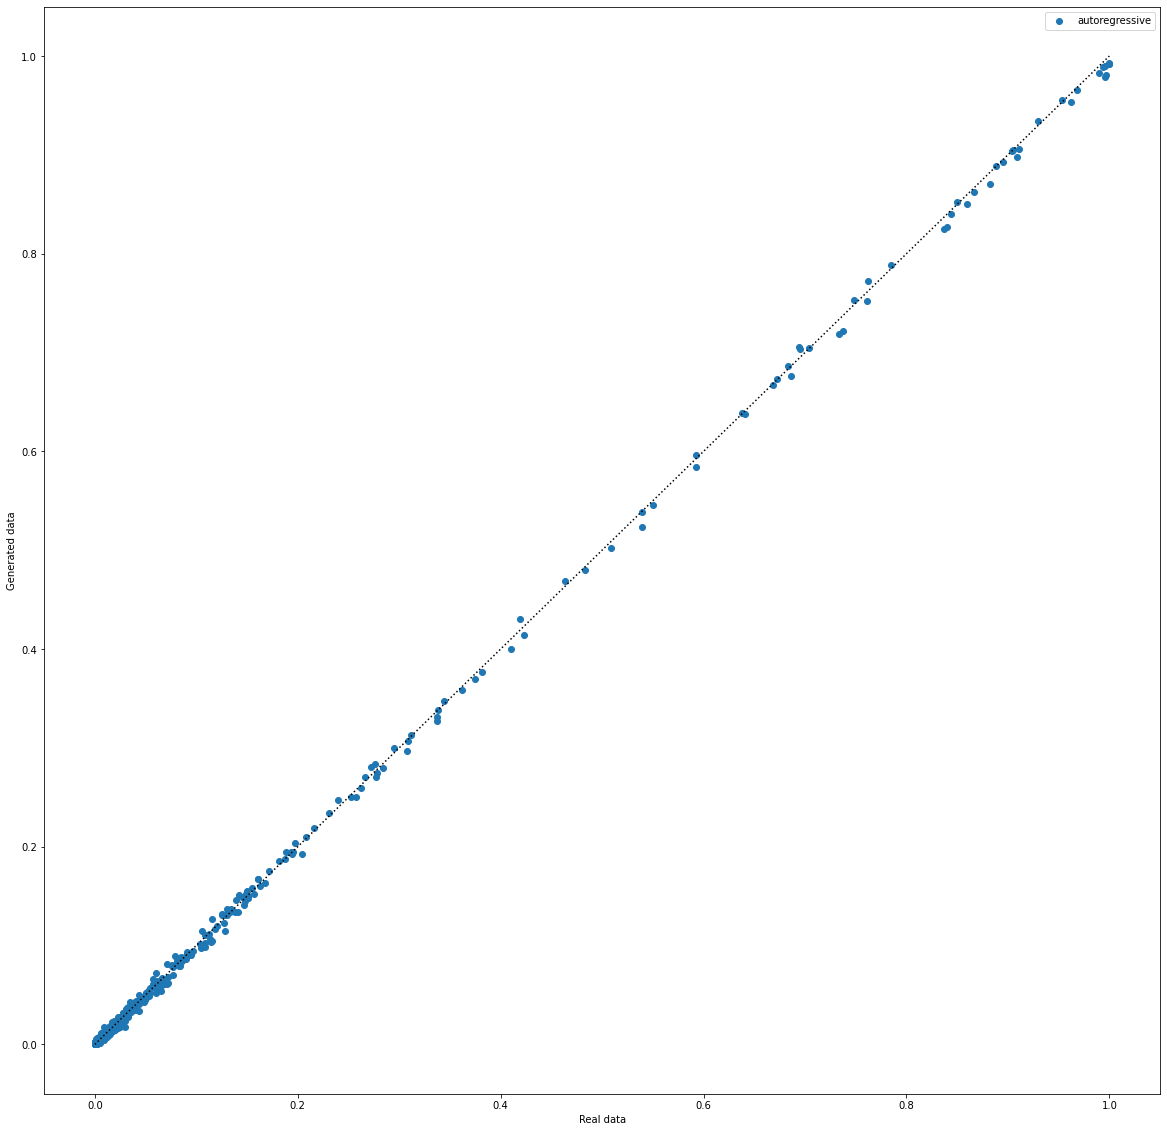

In [64]:
px=np.mean(y,axis=0)
pg=np.mean(seqs,axis=0)
if comparetodata is not None:
    pxc=np.mean(xc,axis=0)
    plt.scatter(px,pxc,label='other method')
plt.plot([0,1.],[0.,1.],c='black',linestyle=':')
plt.scatter(px,pg,label='autoregressive')
plt.xlabel('Real data')
plt.ylabel('Generated data')
plt.legend()

### Compare two-sites frequencies

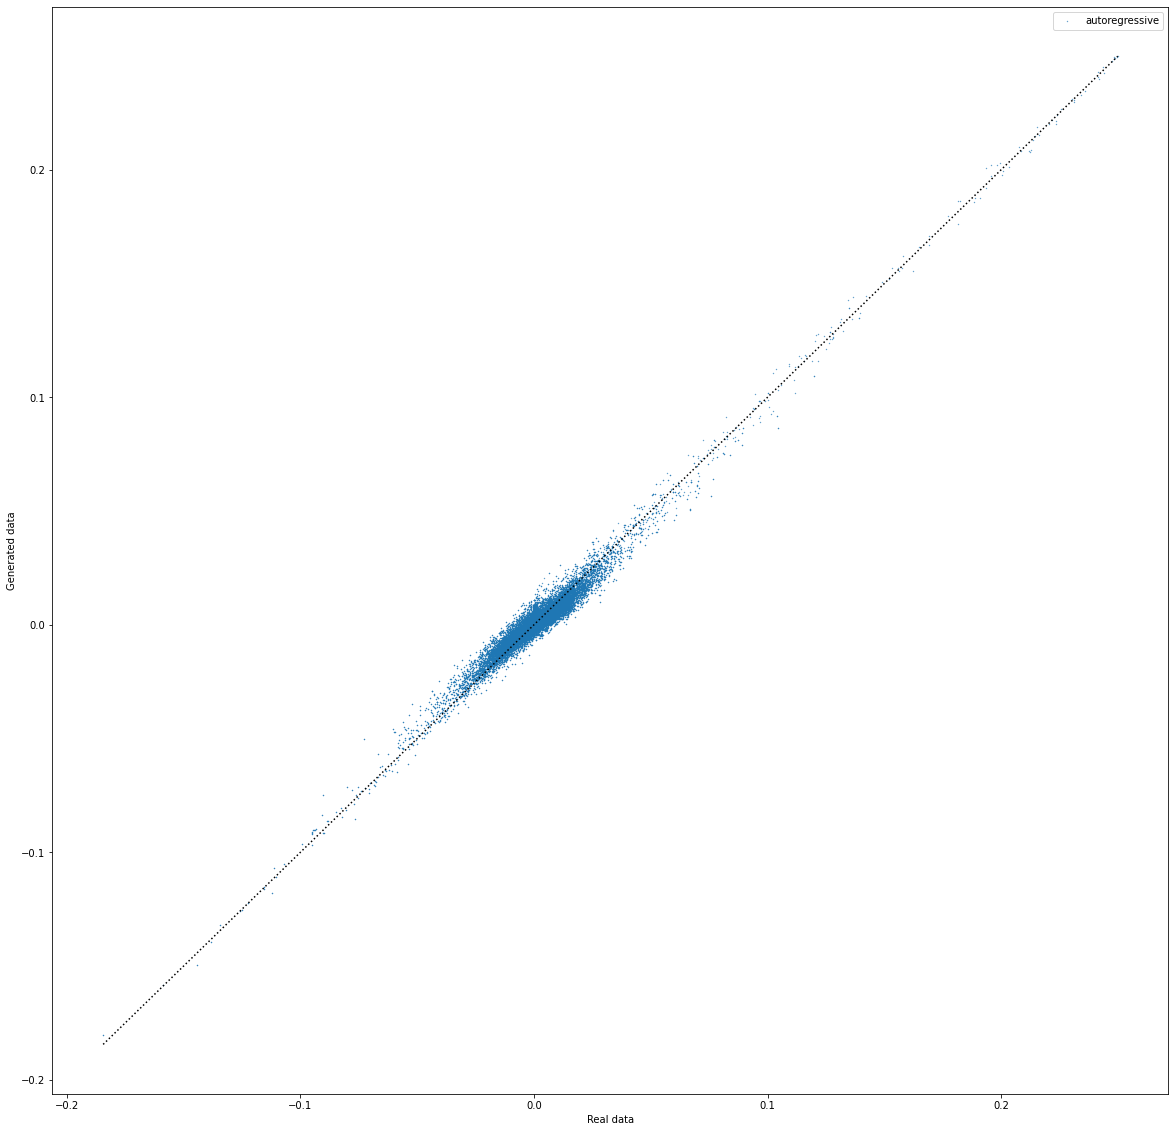

In [65]:
ppx=(np.matmul(y.T,y)/y.shape[0]-np.multiply(px[np.newaxis,:],px[:,np.newaxis])).flatten()
ppg=(np.matmul(seqs.T,seqs)/seqs.shape[0]-np.multiply(pg[np.newaxis,:],pg[:,np.newaxis])).flatten()
if comparetodata is not None:
    ppxc=(np.matmul(xc.T,xc)/xc.shape[0]-np.multiply(pxc[np.newaxis,:],pxc[:,np.newaxis])).flatten()
    plt.scatter(ppx,ppxc,s=0.1, label='other method')
plt.scatter(ppx,ppg,s=0.1,label='autoregressive')
plt.plot([np.min(ppx),np.max(ppx)],[np.min(ppx),np.max(ppx)],c='black',linestyle=':')

plt.xlabel('Real data')
plt.ylabel('Generated data')
plt.legend()

### Compare energy histograms

In [66]:
modelEne=tf.keras.models.Model(In,energy)

try:
    modelEne.load_weights("checkpoints/{}_weights".format(outbasename)).expect_partial()
except:
    print("Cannot load weights")

Run fst-encode

In [68]:
#seqs=np.load("{}_generated.npy".format(outbasename)).astype(float)
xene=np.multiply(modelEne.predict(x).reshape(y.shape),y).sum(axis=1)
gene=np.multiply(modelEne.predict(seqsint).reshape(seqs.shape),seqs).sum(axis=1)
if comparetodata is not None:
    xcene=np.multiply(modelEne.predict(xc).reshape(xc.shape),xc).sum(axis=1)

minene=min(np.min(xene),np.min(gene))
maxene=max(np.max(xene),np.max(gene))

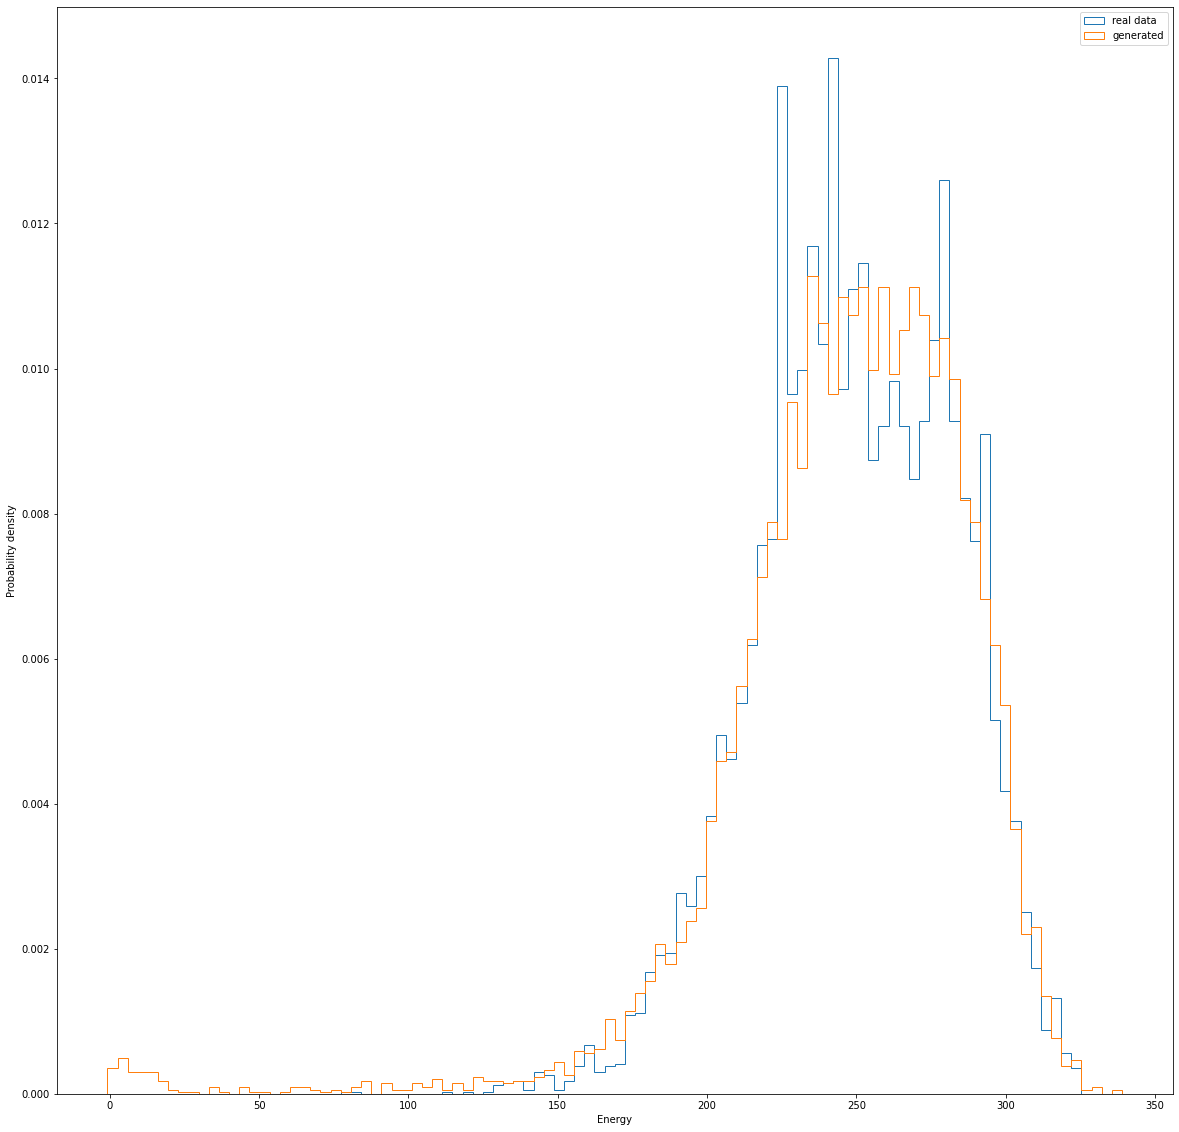

In [69]:
xene_h=plt.hist(xene,100,(minene,maxene),density=True,label='real data',histtype='step')
gene_h=plt.hist(gene,100,(minene,maxene),density=True,label='generated',histtype='step')
if comparetodata is not None:
    xcene_h=plt.hist(xcene,100,(minene,maxene),density=True,label='other method',histtype='step')
plt.xlabel("Energy")
plt.ylabel("Probability density")
plt.legend()

### Compare PCA projection

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(y)

PCA(n_components=2)

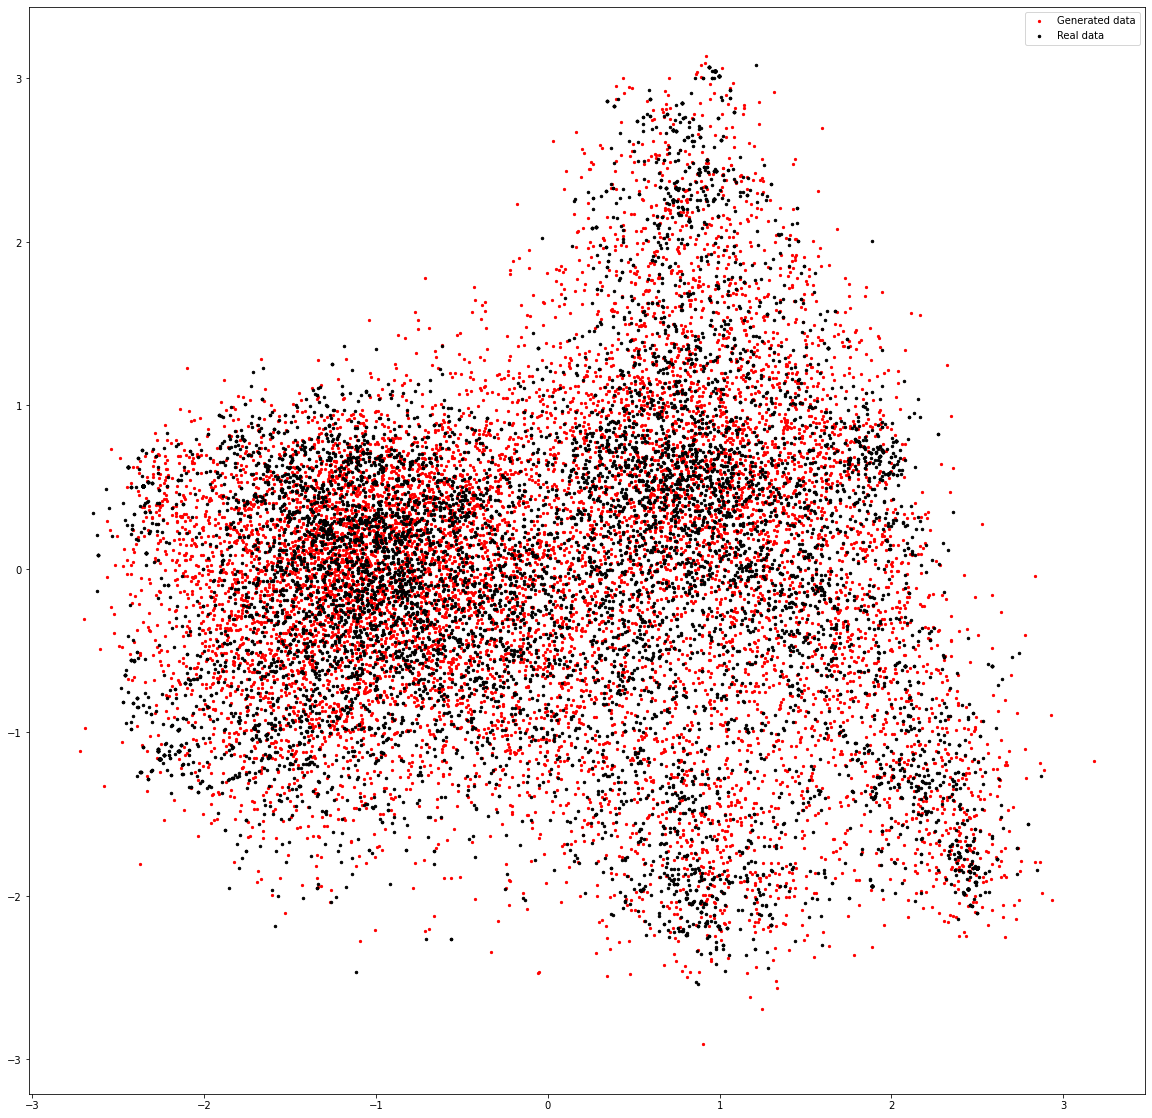

In [71]:
xpca=pca.transform(y)
gpca=pca.transform(seqs)
if comparetodata is not None:
    xcpca=pca.transform(xc)

plt.scatter(gpca[:,0],gpca[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcpca[:,0],xcpca[:,1], c='green',label='Other method')
plt.scatter(xpca[:,0],xpca[:,1], s=6, c='black',label='Real data')
plt.legend()

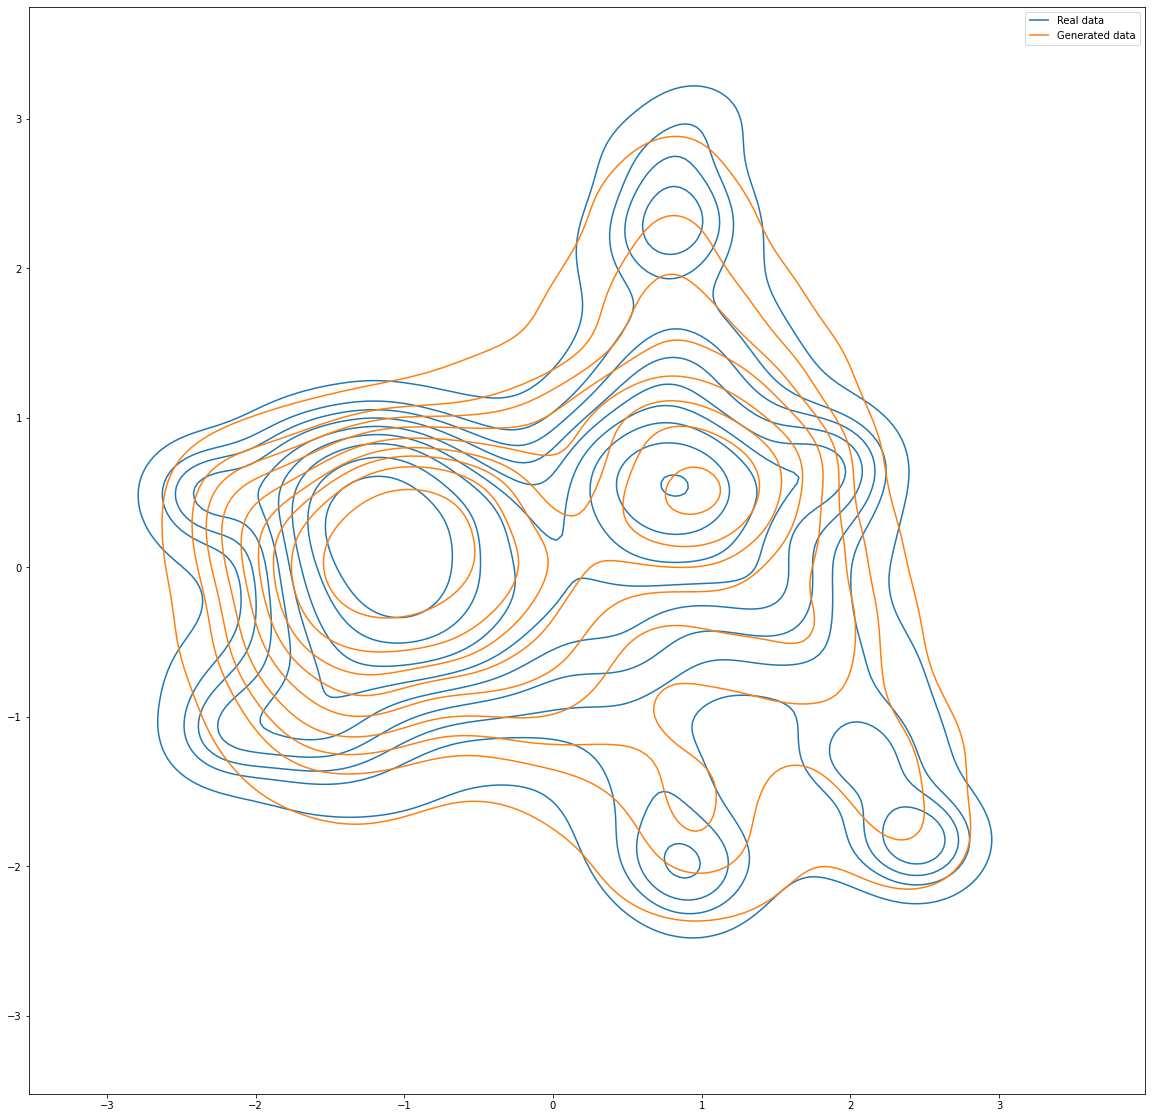

In [72]:
sns.kdeplot(x=xpca[:,0], y=xpca[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gpca[:,0], y=gpca[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()

In [73]:
likelihood=tf.keras.layers.Lambda(lambda x: K.sum(x,axis=1), output_shape=lambda s: (s[0], s[2]))(Out)
model_likelihood=tf.keras.models.Model(In,likelihood)

try:
    model_likelihood.load_weights("{}_weights".format(outbasename)).expect_partial()
except:
    print("Cannot load weights")

In [74]:
InEmb=tf.keras.layers.Input(2)
modelEmb=tf.keras.models.Model(In,Emb)

In [75]:
resEmb=modelEmb.predict([[i] for i in range(21)]).squeeze()

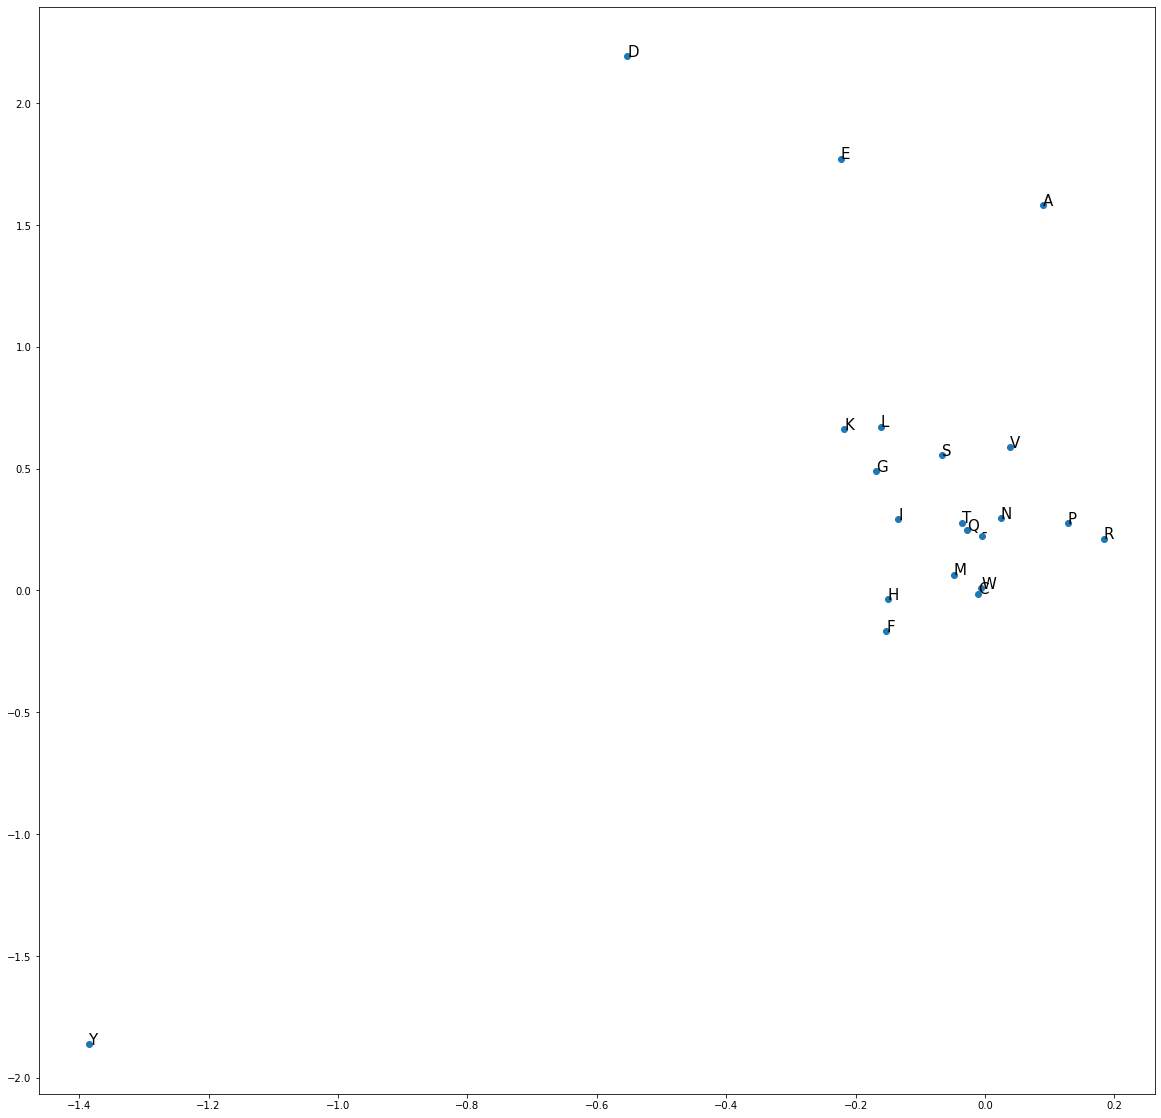

In [76]:
fig, ax = plt.subplots()
ax.scatter(resEmb[:,0],resEmb[:,1])
text=[k for k in profiledata.index[0].keys()]

for i, txt in enumerate(text):
    ax.annotate(txt, (resEmb[i,0], resEmb[i,1]),size=15)
